# 11장 – 심층 신경망 훈련하기

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 그레이디언트 소실과 폭주 문제

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

그림 저장: sigmoid_saturation_plot


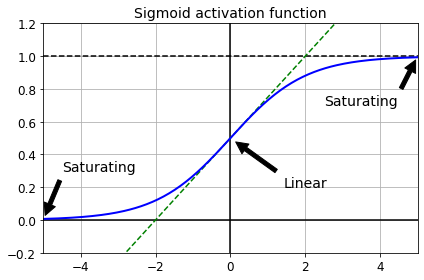

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-') # plot의 범위 지정
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2) # 로지스틱 함수 사용
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

로지스틱 활성화 함수의 선형과 수렴에 대해서 나타내고 있다.

## Xavier 초기화와 He 초기화

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

he_normal 방식으로 초기화 지정

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

fan_in 대신 fan_avg 기반의 균등분포 초기화를 사용하고자 할 때 사용함.

## 수렴하지 않는 활성화 함수

### LeakyReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

그림 저장: leaky_relu_plot


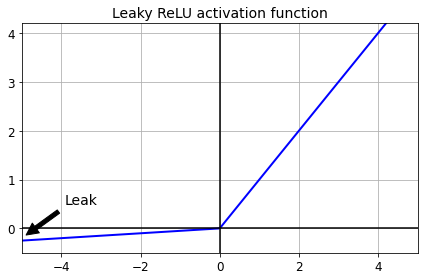

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

LeakyReLU 활성화 함수의 plot 이다. 
- 기울기가 활성화 함수를 죽지 않게 만들어주는 역할을 한다.

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

LeakyReLU를 사용해 패션 MNIST에서 신경망을 훈련

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

은닉층 사이 LeakyReLU 활성화 함수를 넣어준 모델

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [14]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 5ms/step - loss: 1.2909 - accuracy: 0.6034 - val_loss: 0.8844 - val_accuracy: 0.7238
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7989 - accuracy: 0.7412 - val_loss: 0.7093 - val_accuracy: 0.7702
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.6823 - accuracy: 0.7750 - val_loss: 0.6392 - val_accuracy: 0.7908
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.6209 - accuracy: 0.7948 - val_loss: 0.5848 - val_accuracy: 0.8098
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5816 - accuracy: 0.8064 - val_loss: 0.5528 - val_accuracy: 0.8204
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5535 - accuracy: 0.8142 - val_loss: 0.5299 - val_accuracy: 0.8284
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5323 - accuracy: 0.8204 - val_loss: 0.5110 - val_accuracy

## PReLU

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

LeakyReLU를 이전에 활성화 함수로 사용했던 것을 PReLU로 대체해서 사용

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [17]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 1.3336 - accuracy: 0.5937 - val_loss: 0.9069 - val_accuracy: 0.6980
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.8206 - accuracy: 0.7271 - val_loss: 0.7295 - val_accuracy: 0.7608
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.7026 - accuracy: 0.7685 - val_loss: 0.6579 - val_accuracy: 0.7854
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6384 - accuracy: 0.7912 - val_loss: 0.5996 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5957 - accuracy: 0.8042 - val_loss: 0.5642 - val_accuracy: 0.8192
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5644 - accuracy: 0.8131 - val_loss: 0.5387 - val_accuracy: 0.8240
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5406 - accuracy: 0.8197 - val_loss: 0.5167 - val_accu

### ELU

In [18]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

그림 저장: elu_plot


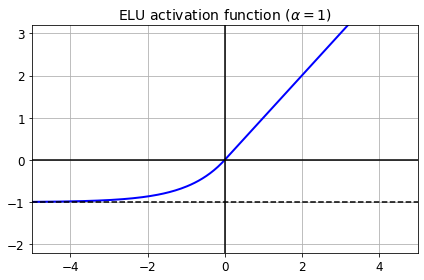

In [19]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

텐서플로에서 쉽게 ELU를 적용할 수 있습니다. 층을 만들 때 활성화 함수로 지정하면 됩니다:

In [20]:
keras.layers.Dense(10, activation="elu")

### SELU

- 훈련하는 동안 완전 연결 층만 쌓아서 신경망을 만들고 SELU 활성화 함수와 LeCun 초기화를 사용한다면 자기 정규화됩니다. 
- 각 층의 출력이 평균과 표준편차를 보존하는 경향 존재
    - 이는 그레이디언트 소실과 폭주 문제를 막아준다.
    - 그 결과로 SELU 활성화 함수는 이런 종류의 네트워크(특히 아주 깊은 네트워크)에서 다른 활성화 함수보다 뛰어난 성능을 종종 낸다

In [21]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화합니다
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [22]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

그림 저장: selu_plot


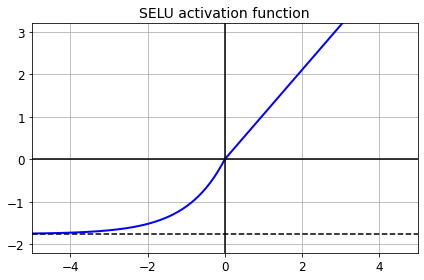

In [23]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

- 기본적으로 SELU 하이퍼파라미터(`scale`과 `alpha`)는 각 뉴런의 평균 출력이 0에 가깝고 표준 편차는 1에 가깝도록 조정
- 이 활성화 함수를 사용하면 1,000개의 층이 있는 심층 신경망도 모든 층에 걸쳐 거의 평균이 0이고 표준 편차를 1로 유지
=> 이를 통해 그레이디언트 폭주와 소실 문제를 피할 수 있음

In [24]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # 표준화된 입력
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


쉽게 SELU를 사용할 수 있습니다:

In [25]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

100개의 은닉층과 SELU 활성화 함수를 사용한 패션 MNIST를 위한 신경망

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

이제 훈련해 보죠. 입력을 평균 0과 표준 편차 1로 바꾸어야 한다는 것을 잊지 마세요:

In [29]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [30]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 69s 34ms/step - loss: 1.3855 - accuracy: 0.4594 - val_loss: 0.8634 - val_accuracy: 0.6690
Epoch 2/5
1719/1719 [==============================] - 56s 32ms/step - loss: 0.9131 - accuracy: 0.6453 - val_loss: 0.7527 - val_accuracy: 0.7016
Epoch 3/5
1719/1719 [==============================] - 54s 32ms/step - loss: 0.7086 - accuracy: 0.7213 - val_loss: 0.7160 - val_accuracy: 0.7372
Epoch 4/5
1719/1719 [==============================] - 53s 31ms/step - loss: 0.6023 - accuracy: 0.7805 - val_loss: 0.6451 - val_accuracy: 0.7690
Epoch 5/5
1719/1719 [==============================] - 54s 31ms/step - loss: 0.5526 - accuracy: 0.8071 - val_loss: 0.5466 - val_accuracy: 0.8186


대신 ReLU 활성화 함수를 사용하면 어떤 일이 일어나는지 확인해 보죠:

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

ReLU 사용

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [34]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 43s 19ms/step - loss: 2.0549 - accuracy: 0.2009 - val_loss: 1.8803 - val_accuracy: 0.3556
Epoch 2/5
1719/1719 [==============================] - 14s 8ms/step - loss: 1.5634 - accuracy: 0.4004 - val_loss: 1.2184 - val_accuracy: 0.4918
Epoch 3/5
1719/1719 [==============================] - 16s 10ms/step - loss: 1.1427 - accuracy: 0.5169 - val_loss: 1.0704 - val_accuracy: 0.5478
Epoch 4/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.9260 - accuracy: 0.6245 - val_loss: 0.8891 - val_accuracy: 0.6258
Epoch 5/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.8468 - accuracy: 0.6734 - val_loss: 1.0624 - val_accuracy: 0.6024


그레이디언트 폭주나 소실 문제가 발생

# 배치 정규화

In [35]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

배치 정규화 구현

In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_212 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_213 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

In [37]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [38]:
# updates 속성은 향후 삭제될 예정입니다.
# bn1.updates

In [39]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [40]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.8372 - accuracy: 0.7229 - val_loss: 0.5567 - val_accuracy: 0.8128
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5766 - accuracy: 0.7999 - val_loss: 0.4785 - val_accuracy: 0.8388
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5207 - accuracy: 0.8188 - val_loss: 0.4446 - val_accuracy: 0.8460
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4830 - accuracy: 0.8315 - val_loss: 0.4223 - val_accuracy: 0.8510
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4591 - accuracy: 0.8370 - val_loss: 0.4065 - val_accuracy: 0.8556
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4423 - accuracy: 0.8447 - val_loss: 0.3950 - val_accuracy: 0.8626
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4268 - accuracy: 0.8496 - val_loss: 0.3850 - val_accuracy:

이따금 활성화 함수전에 BN을 적용해도 잘 동작합니다(여기에는 논란의 여지가 있습니다). 또한 `BatchNormalization` 층 이전의 층은 편향을 위한 항이 필요 없습니다. `BatchNormalization` 층이 이를 무효화하기 때문입니다. 따라서 필요 없는 파라미터이므로 `use_bias=False`를 지정하여 층을 만들 수 있습니다:

In [41]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

활성화 함수 추가 모델

In [42]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [43]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 1.0732 - accuracy: 0.6717 - val_loss: 0.6778 - val_accuracy: 0.7864
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6831 - accuracy: 0.7804 - val_loss: 0.5527 - val_accuracy: 0.8230
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5972 - accuracy: 0.8022 - val_loss: 0.4977 - val_accuracy: 0.8376
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5436 - accuracy: 0.8187 - val_loss: 0.4634 - val_accuracy: 0.8446
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5109 - accuracy: 0.8267 - val_loss: 0.4405 - val_accuracy: 0.8532
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4879 - accuracy: 0.8339 - val_loss: 0.4226 - val_accuracy: 0.8564
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4721 - accuracy: 0.8376 - val_loss: 0.4098 - val_accuracy:

## 그레이디언트 클리핑

모든 케라스 옵티마이저는 `clipnorm`이나 `clipvalue` 매개변수를 지원합니다:

In [44]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [45]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## 사전 훈련된 층 재사용하기

### 케라스 모델 재사용하기

패션 MNIST 훈련 세트를 두 개로 분류
* `X_train_A`: 샌달과 셔츠(클래스 5와 6)을 제외한 모든 이미지
* `X_train_B`: 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트

검증 세트와 테스트 세트도 이렇게 나눕니다. 하지만 이미지 개수는 제한하지 않습니다.

- A세트에서 모델을 훈련하고 재사용하여 B 세트 해결
- A 작업에서 B작업으로의 지식 전달 -> A세트의 클래스와 B 세트의 클래스와 유사

Dense 층을 사용하기 떄문에 동일 위치에 나타난 패턴만 재사용 가능

In [46]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [47]:
X_train_A.shape

(43986, 28, 28)

In [48]:
X_train_B.shape

(200, 28, 28)

In [49]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [50]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [51]:
tf.random.set_seed(42)
np.random.seed(42)

In [52]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [53]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [54]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.6045 - accuracy: 0.8028 - val_loss: 0.3942 - val_accuracy: 0.8612
Epoch 2/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.3620 - accuracy: 0.8758 - val_loss: 0.3229 - val_accuracy: 0.8894
Epoch 3/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.3192 - accuracy: 0.8890 - val_loss: 0.2943 - val_accuracy: 0.8984
Epoch 4/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2979 - accuracy: 0.8966 - val_loss: 0.2797 - val_accuracy: 0.9046
Epoch 5/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.2841 - accuracy: 0.9017 - val_loss: 0.2696 - val_accuracy: 0.9093
Epoch 6/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2742 - accuracy: 0.9062 - val_loss: 0.2647 - val_accuracy: 0.9071
Epoch 7/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2659 - accuracy: 0.9084 - val_loss: 0.2630 - val_accuracy:

In [55]:
model_A.save("my_model_A.h5")

In [56]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [57]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [58]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 2s 105ms/step - loss: 0.5608 - accuracy: 0.7000 - val_loss: 0.4741 - val_accuracy: 0.7708
Epoch 2/20
7/7 [==============================] - 0s 17ms/step - loss: 0.4199 - accuracy: 0.8000 - val_loss: 0.3745 - val_accuracy: 0.8600
Epoch 3/20
7/7 [==============================] - 0s 16ms/step - loss: 0.3293 - accuracy: 0.9150 - val_loss: 0.3119 - val_accuracy: 0.9006
Epoch 4/20
7/7 [==============================] - 0s 16ms/step - loss: 0.2737 - accuracy: 0.9550 - val_loss: 0.2679 - val_accuracy: 0.9310
Epoch 5/20
7/7 [==============================] - 0s 24ms/step - loss: 0.2338 - accuracy: 0.9600 - val_loss: 0.2359 - val_accuracy: 0.9493
Epoch 6/20
7/7 [==============================] - 0s 32ms/step - loss: 0.2038 - accuracy: 0.9650 - val_loss: 0.2107 - val_accuracy: 0.9594
Epoch 7/20
7/7 [==============================] - 0s 23ms/step - loss: 0.1806 - accuracy: 0.9750 - val_loss: 0.1929 - val_accuracy: 0.9615
Epoch 8/20
7/7 [==========

In [59]:
model_B.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_224 (Dense)           (None, 300)               235500    
                                                                 
 dense_225 (Dense)           (None, 100)               30100     
                                                                 
 dense_226 (Dense)           (None, 50)                5050      
                                                                 
 dense_227 (Dense)           (None, 50)                2550      
                                                                 
 dense_228 (Dense)           (None, 50)                2550      
                                                                 
 dense_229 (Dense)           (None, 1)                

In [60]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

`model_B_on_A`와 `model_A`는 층을 공유하기 때문에 하나를 훈련하면 두 모델이 업데이트됩니다. 

이를 피하려면 `model_A`를 클론한 것을 사용해 `model_B_on_A`를 만들어야 합니다:

In [61]:
model_A_clone = keras.models.clone_model(model_A) #keras를 통한 A 모델 복제
model_A_clone.set_weights(model_A.get_weights()) # 가중치 복제
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [62]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [63]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 85ms/step - loss: 0.5373 - accuracy: 0.7250 - val_loss: 0.6168 - val_accuracy: 0.6826
Epoch 2/4
7/7 [==============================] - 0s 16ms/step - loss: 0.5080 - accuracy: 0.7350 - val_loss: 0.5874 - val_accuracy: 0.6978
Epoch 3/4
7/7 [==============================] - 0s 15ms/step - loss: 0.4806 - accuracy: 0.7400 - val_loss: 0.5601 - val_accuracy: 0.7140
Epoch 4/4
7/7 [==============================] - 0s 28ms/step - loss: 0.4552 - accuracy: 0.7550 - val_loss: 0.5354 - val_accuracy: 0.7343
Epoch 1/16
7/7 [==============================] - 1s 92ms/step - loss: 0.3383 - accuracy: 0.8550 - val_loss: 0.3010 - val_accuracy: 0.9097
Epoch 2/16
7/7 [==============================] - 0s 20ms/step - loss: 0.2051 - accuracy: 0.9650 - val_loss: 0.2233 - val_accuracy: 0.9513
Epoch 3/16
7/7 [==============================] - 0s 14ms/step - loss: 0.1554 - accuracy: 0.9850 - val_loss: 0.1841 - val_accuracy: 0.9675
Epoch 4/16
7/7 [===============

마지막 점수는 어떤가요?

In [64]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.0928 - accuracy: 0.9815


[0.09284326434135437, 0.9815000295639038]

In [65]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.0656 - accuracy: 0.9920


[0.06558898091316223, 0.9919999837875366]

훌륭하네요! 꽤 많은 정보를 전달했습니다: 오차율이 4.9배나 줄었네요!

In [66]:
(100 - 97.05) / (100 - 99.40)

4.916666666666718

# 고속 옵티마이저

## 모멘텀 옵티마이저

In [67]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

## 네스테로프 가속 경사

In [68]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

## AdaGrad

In [69]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

## RMSProp

In [70]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

## Adam 옵티마이저

In [71]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Adamax 옵티마이저

In [72]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Nadam 옵티마이저

In [73]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## 학습률 스케줄링

### 거듭제곱 스케줄링

```lr = lr0 / (1 + steps / s)**c```
* 케라스는 `c=1`과 `s = 1 / decay`을 사용합니다

In [74]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [75]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [76]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4871 - accuracy: 0.8282 - val_loss: 0.4119 - val_accuracy: 0.8572
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3806 - accuracy: 0.8652 - val_loss: 0.3818 - val_accuracy: 0.8666
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3482 - accuracy: 0.8755 - val_loss: 0.3801 - val_accuracy: 0.8702
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3270 - accuracy: 0.8825 - val_loss: 0.3571 - val_accuracy: 0.8770
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3116 - accuracy: 0.8889 - val_loss: 0.3521 - val_accuracy: 0.8752
Epoch 6/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2980 - accuracy: 0.8946 - val_loss: 0.3493 - val_accuracy: 0.8776
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2881 - accuracy: 0.8982 - val_loss: 0.3475 - val_accuracy:

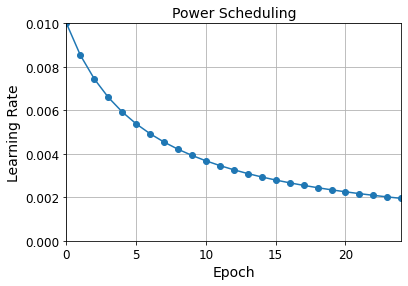

In [77]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 지수 기반 스케줄링

```lr = lr0 * 0.1**(epoch / s)```

학습률이 s 스텝마다 10배씩 점차 줄어들음 -> 거듭제곱 기반은 학습률이 갈수록 감소, 지수기반은 s번 스텝마다 10배씩 감소

In [78]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [79]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [80]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [81]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8513 - accuracy: 0.7531 - val_loss: 0.8886 - val_accuracy: 0.7132 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6760 - accuracy: 0.7976 - val_loss: 0.7270 - val_accuracy: 0.8162 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6356 - accuracy: 0.8100 - val_loss: 0.6359 - val_accuracy: 0.8254 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5631 - accuracy: 0.8294 - val_loss: 0.6169 - val_accuracy: 0.8394 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4960 - accuracy: 0.8463 - val_loss: 0.4688 - val_accuracy: 0.8592 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4498 - accuracy: 0.8587 - val_loss: 0.4674 - val_accuracy: 0.8508 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 6s

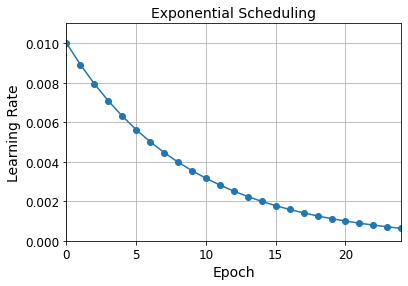

In [82]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

이 스케줄 함수는 두 번째 매개변수로 현재 학습률을 받을 수 있습니다:

In [83]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

에포크가 아니라 반복마다 학습률을 업데이트하려면 사용자 정의 콜백 클래스를 작성해야 합니다:

In [84]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # 노트: 에포크마다 `batch` 매개변수가 재설정됩니다
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # 20 에포크 동안 스텝 횟수 (배치 크기 = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 10s 5ms/step - loss: 0.8029 - accuracy: 0.7649 - val_loss: 0.8729 - val_accuracy: 0.7412 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.6330 - accuracy: 0.8040 - val_loss: 0.6496 - val_accuracy: 0.8196 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5587 - accuracy: 0.8260 - val_loss: 0.6948 - val_accuracy: 0.7944 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5023 - accuracy: 0.8404 - val_loss: 0.4598 - val_accuracy: 0.8564 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4657 - accuracy: 0.8541 - val_loss: 0.4658 - val_accuracy: 0.8750 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4308 - accuracy: 0.8623 - val_loss: 0.4706 - val_accuracy: 0.8580 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 1

In [85]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

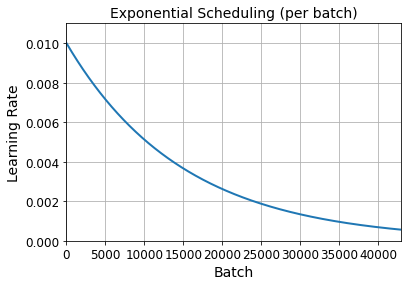

In [86]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### 기간별 고정 스케줄링

일정 횟수의 에포크 동안 일정 학습률을 사용하고, 다른 횟수의 에포크 동안 작은 학습률을 사용하는 방법

In [87]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [88]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [89]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 9s 4ms/step - loss: 0.8253 - accuracy: 0.7610 - val_loss: 1.0720 - val_accuracy: 0.6730 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8130 - accuracy: 0.7638 - val_loss: 0.7956 - val_accuracy: 0.7618 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 1.0812 - accuracy: 0.6795 - val_loss: 1.1817 - val_accuracy: 0.5778 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.9365 - accuracy: 0.7273 - val_loss: 1.0723 - val_accuracy: 0.7218 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.9127 - accuracy: 0.7331 - val_loss: 0.8140 - val_accuracy: 0.7448 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5939 - accuracy: 0.8173 - val_loss: 0.6253 - val_accuracy: 0.8242 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 7s

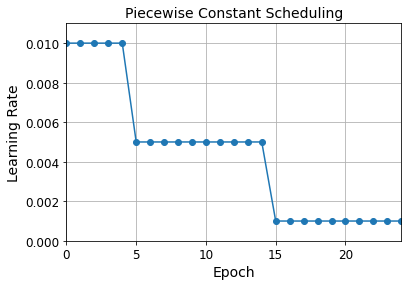

In [90]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 성능 기반 스케줄링

매 N 스탭마다 검증 오차를 측정하고 오차가 줄지 않으면 람다배만큼 학습률을 감소시킨다

In [91]:
tf.random.set_seed(42)
np.random.seed(42)

In [92]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6003 - accuracy: 0.8056 - val_loss: 0.5262 - val_accuracy: 0.8420 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5080 - accuracy: 0.8388 - val_loss: 0.6192 - val_accuracy: 0.8336 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5131 - accuracy: 0.8409 - val_loss: 0.5487 - val_accuracy: 0.8406 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5194 - accuracy: 0.8455 - val_loss: 0.4931 - val_accuracy: 0.8486 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5324 - accuracy: 0.8461 - val_loss: 0.5416 - val_accuracy: 0.8364 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5121 - accuracy: 0.8521 - val_loss: 0.5735 - val_accuracy: 0.8540 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 6s

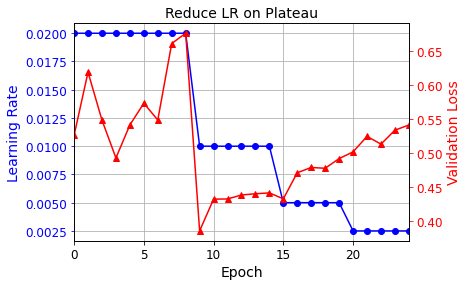

In [93]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras 스케줄러

In [94]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4873 - accuracy: 0.8292 - val_loss: 0.4007 - val_accuracy: 0.8608
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3784 - accuracy: 0.8659 - val_loss: 0.3691 - val_accuracy: 0.8702
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3457 - accuracy: 0.8771 - val_loss: 0.3712 - val_accuracy: 0.8688
Epoch 4/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3239 - accuracy: 0.8846 - val_loss: 0.3462 - val_accuracy: 0.8788
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3086 - accuracy: 0.8909 - val_loss: 0.3404 - val_accuracy: 0.8782
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2942 - accuracy: 0.8960 - val_loss: 0.3396 - val_accuracy: 0.8790
Epoch 7/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2839 - accuracy: 0.8994 - val_loss: 0.3338 - val_accuracy:

구간별 고정 스케줄링은 다음을 사용하세요:

In [95]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1사이클 스케줄링

훈련 절반동안 초기 학습률을 선형적으로 증가 -> 나머지 절반동안 학습률을 다시 줄임

In [96]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

**경고**: `on_batch_end()` 메서드에서 `logs["loss"]`로 배치 손실을 모으지만 텐서플로 2.2.0에서 (에포크의) 평균 손실로 바뀌었습니다. (텐서플로 2.2 이상을 사용한다면) 이런 이유로 아래 그래프가 이전보다 훨씬 부드럽습니다. 이는 그래프에서 배치 손실이 폭주하기 시작하는 지점과 그렇지 않은 지점 사이에 지연이 있다는 뜻입니다. 따라서 변동이 심한 그래프에서는 조금 더 작은 학습률을 선택해야 합니다. 또한 `ExponentialLearningRate` 콜백을 조금 바꾸어 (현재 평균 손실과 이전 평균 손실을 기반으로) 배치 손실을 계산할 수 있습니다:

```python
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0
    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
```

In [97]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.3698


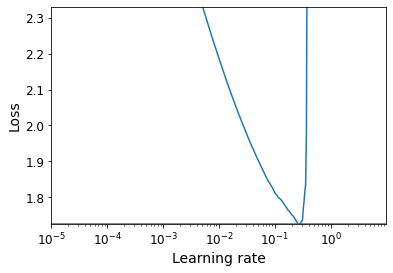

In [98]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [99]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [100]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 3s 7ms/step - loss: 0.6607 - accuracy: 0.7697 - val_loss: 0.4921 - val_accuracy: 0.8330
Epoch 2/25
430/430 [==============================] - 2s 5ms/step - loss: 0.4630 - accuracy: 0.8388 - val_loss: 0.4332 - val_accuracy: 0.8522
Epoch 3/25
430/430 [==============================] - 2s 5ms/step - loss: 0.4167 - accuracy: 0.8537 - val_loss: 0.4137 - val_accuracy: 0.8562
Epoch 4/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3875 - accuracy: 0.8640 - val_loss: 0.3856 - val_accuracy: 0.8654
Epoch 5/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3668 - accuracy: 0.8705 - val_loss: 0.3753 - val_accuracy: 0.8652
Epoch 6/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3477 - accuracy: 0.8762 - val_loss: 0.3716 - val_accuracy: 0.8706
Epoch 7/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3334 - accuracy: 0.8804 - val_loss: 0.3561 - val_accuracy: 0.8714
Epoch 

# 규제를 사용해 과대적합 피하기

## $\ell_1$과 $\ell_2$ 규제

In [101]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

규제 손실을 계산하기 위해 각 스텝에서 호출되는 규제 객체 반환

- 케라스의 연결 가중치에 규제 강도 0.01 사용

In [102]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 8s 4ms/step - loss: 1.5937 - accuracy: 0.8117 - val_loss: 0.7135 - val_accuracy: 0.8330
Epoch 2/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7175 - accuracy: 0.8288 - val_loss: 0.6821 - val_accuracy: 0.8374


In [103]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 5ms/step - loss: 1.6547 - accuracy: 0.8124 - val_loss: 0.7192 - val_accuracy: 0.8320
Epoch 2/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.7171 - accuracy: 0.8271 - val_loss: 0.6803 - val_accuracy: 0.8396


## 드롭아웃

In [104]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2), #드롭아웃 함수 사용
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 12s 6ms/step - loss: 0.5711 - accuracy: 0.8024 - val_loss: 0.3729 - val_accuracy: 0.8618
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4198 - accuracy: 0.8463 - val_loss: 0.3451 - val_accuracy: 0.8708


## 알파 드롭아웃

In [105]:
tf.random.set_seed(42)
np.random.seed(42)

In [106]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 12s 6ms/step - loss: 0.6640 - accuracy: 0.7595 - val_loss: 0.5986 - val_accuracy: 0.8402
Epoch 2/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5572 - accuracy: 0.7950 - val_loss: 0.5663 - val_accuracy: 0.8394
Epoch 3/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5263 - accuracy: 0.8047 - val_loss: 0.5096 - val_accuracy: 0.8584
Epoch 4/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5099 - accuracy: 0.8108 - val_loss: 0.4778 - val_accuracy: 0.8578
Epoch 5/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4927 - accuracy: 0.8168 - val_loss: 0.4433 - val_accuracy: 0.8674
Epoch 6/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4839 - accuracy: 0.8202 - val_loss: 0.4728 - val_accuracy: 0.8606
Epoch 7/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4691 - accuracy: 0.8258 - val_loss: 0.4916 - val_acc

In [107]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4878 - accuracy: 0.8535


[0.4878104627132416, 0.8535000085830688]

In [108]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 6s 3ms/step - loss: 0.3693 - accuracy: 0.8739


[0.3692581355571747, 0.8738545179367065]

In [109]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 10s 6ms/step - loss: 0.4199 - accuracy: 0.8448


## MC 드롭아웃

드롭아웃 모델을 재훈련하거나 전혀 수정하지 않고도 성능을 향상할 수 있는 방법

In [110]:
tf.random.set_seed(42)
np.random.seed(42)

In [111]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [112]:
np.round(model.predict(X_test_scaled[:1]), 2)

1/1 [==============================] - 0s 169ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [113]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.11, 0.  , 0.78]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.96]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.06, 0.  , 0.92]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.39, 0.  , 0.58]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.44, 0.  , 0.53]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.52, 0.  , 0.47]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.1 , 0.  , 0.89]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.17, 0.  , 0.35, 0.  , 0.48]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.04, 0.  , 0.93]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.39, 0.  , 0.09, 0.  , 0.51]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.01, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.27, 0.  , 0

In [114]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.19, 0.  , 0.74]],
      dtype=float32)

drop out에 대한 예측 결과와 같다.

In [115]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.2 , 0.  , 0.23]],
      dtype=float32)

In [116]:
y_pred = np.argmax(y_proba, axis=1)

In [117]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8675

In [118]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

드롭아웃 층 상속 -> call 메서드를 오버라이드 하여 training 변수를 true로 강제로 설정

In [119]:
tf.random.set_seed(42)
np.random.seed(42)

In [120]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [121]:
mc_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 784)               0         
                                                                 
 mc_alpha_dropout (MCAlphaDr  (None, 784)              0         
 opout)                                                          
                                                                 
 dense_263 (Dense)           (None, 300)               235500    
                                                                 
 mc_alpha_dropout_1 (MCAlpha  (None, 300)              0         
 Dropout)                                                        
                                                                 
 dense_264 (Dense)           (None, 100)               30100     
                                                                 
 mc_alpha_dropout_2 (MCAlpha  (None, 100)            

In [122]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [123]:
mc_model.set_weights(model.get_weights())

이제 MC 드롭아웃을 모델에 사용할 수 있습니다:

In [124]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

1/1 [==============================] - 0s 30ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.19, 0.  , 0.7 ]],
      dtype=float32)

## 맥스 노름

뉴런에 대해 이볅의 연결 가중치가 ||w||2<=r이 되도록 제한

In [125]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [126]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4740 - accuracy: 0.8333 - val_loss: 0.3678 - val_accuracy: 0.8702
Epoch 2/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3528 - accuracy: 0.8717 - val_loss: 0.3705 - val_accuracy: 0.8650
